In [1]:
!pip uninstall -y flash-attn flash_attn 2>/dev/null
!pip install -q "transformers>=4.46.0" datasets evaluate accelerate

In [2]:
import torch, platform
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
!nvidia-smi -L || true

Torch: 2.6.0+cu124 | CUDA available: True
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-24d2e2d8-f9b2-6dab-9cec-63008accf7f1)


# Import

In [3]:
import os
os.environ["DISABLE_FLASH_ATTN"] = "1"

In [4]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers.optimization import get_linear_schedule_with_warmup
import evaluate
from tqdm import tqdm

2025-08-21 07:55:56.568212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755762956.590748     233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755762956.597572     233 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Tokenizer

In [7]:
MODEL_ID = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
MAX_LEN = 128

# Dataset

In [8]:
raw_ds = load_dataset("glue", "sst2")

In [9]:
def tok_fn(batch):
    return tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

In [10]:
train_ds = raw_ds["train"].map(tok_fn, batched=True)
val_ds   = raw_ds["validation"].map(tok_fn, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

In [11]:
# HuggingFace datasets -> torch
train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [12]:
len(train_ds)

67349

In [13]:
len(val_ds)

872

# DataLoader

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader))

Batches: 2105 14


# ModernBERT Classifier (không có flash-attn)

In [15]:
class ModernBERTClassifier(nn.Module):
    def __init__(self, model_name: str, num_labels: int = 2, dropout: float = 0.1):
        super().__init__()
        
        self.backbone = AutoModel.from_pretrained(model_name, torch_dtype=torch.float32)
        hidden = self.backbone.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        
        cls = out.last_hidden_state[:, 0]         
        cls = self.dropout(cls)
        logits = self.classifier(cls)              

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return logits, loss


In [16]:
model = ModernBERTClassifier(MODEL_ID, num_labels=2).to(device)

# Optimizer, Scheduler, AWP

In [17]:
LR = 2e-5
EPOCHS = 20
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06      
GRAD_ACCUM_STEPS = 1     
MAX_GRAD_NORM = 1.0

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [19]:
total_steps = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

In [20]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

In [21]:
# scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

scaler = torch.amp.GradScaler("cuda" if torch.cuda.is_available() else "cpu")

# Eval

In [22]:
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

In [23]:
@torch.no_grad()
def evaluate_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    preds_all, labels_all = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        logits, loss = model(input_ids, attention_mask, labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        preds_all.extend(preds.cpu().tolist())
        labels_all.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(loader)
    acc = metric_acc.compute(predictions=preds_all, references=labels_all)["accuracy"]
    f1  = metric_f1.compute(predictions=preds_all, references=labels_all, average="binary")["f1"]
    return {"val_loss": avg_loss, "val_acc": acc, "val_f1": f1}

# Train thôi

In [24]:
best_val_acc = 0.0
history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

In [25]:
torch._inductor.config.cpp_wrapper = False
torch._inductor.config.triton.cudagraphs = False

In [30]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [31]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(enumerate(train_loader, start=1), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        with torch.amp.autocast("cuda"):
            logits, loss = model(input_ids, attention_mask, labels)
            loss = loss / GRAD_ACCUM_STEPS

        scaler.scale(loss).backward()

        if step % GRAD_ACCUM_STEPS == 0:
            # gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        running += loss.item() * GRAD_ACCUM_STEPS
        if step % 50 == 0:
            pbar.set_postfix(train_loss=f"{running/step:.4f}")

    train_loss = running / len(train_loader)
    val_metrics = evaluate_epoch(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["val_loss"])
    history["val_acc"].append(val_metrics["val_acc"])
    history["val_f1"].append(val_metrics["val_f1"])

    print(f">>> E{epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_loss={val_metrics['val_loss']:.4f} | "
          f"val_acc={val_metrics['val_acc']:.4f} | val_f1={val_metrics['val_f1']:.4f}")

    # Lưu best checkpoint theo accuracy
    if val_metrics["val_acc"] > best_val_acc:
        best_val_acc = val_metrics["val_acc"]
        save_path = "/kaggle/working/modernbert_sst2_best.pt" if "KAGGLE_URL_BASE" in os.environ else "/content/modernbert_sst2_best.pt"
        torch.save({"model_state_dict": model.state_dict(),
                    "model_name": MODEL_ID,
                    "tokenizer": tokenizer.name_or_path,
                    "val_acc": best_val_acc},
                   save_path)
        print(f"Saved best model to: {save_path} (acc={best_val_acc:.4f})")

Epoch 1/20:   0%|          | 0/2105 [00:00<?, ?it/s]W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT compiled_embeddings /usr/local/lib/python3.11/dist-packages/transformers/models/modernbert/modeling_modernbert.py line 204 
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233] due to: 
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0821 07:59:22.443000 233 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0821 07:59:22.443000 233 torch/_dynamo/convert_fr

>>> E01 | train_loss=0.3249 | val_loss=0.1747 | val_acc=0.9392 | val_f1=0.9393
Saved best model to: /kaggle/working/modernbert_sst2_best.pt (acc=0.9392)


Epoch 2/20: 100%|██████████| 2105/2105 [17:59<00:00,  1.95it/s, train_loss=0.1489]


>>> E02 | train_loss=0.1491 | val_loss=0.1517 | val_acc=0.9472 | val_f1=0.9480
Saved best model to: /kaggle/working/modernbert_sst2_best.pt (acc=0.9472)


Epoch 3/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0920]


>>> E03 | train_loss=0.0921 | val_loss=0.1903 | val_acc=0.9450 | val_f1=0.9471


Epoch 4/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0593]


>>> E04 | train_loss=0.0594 | val_loss=0.1990 | val_acc=0.9438 | val_f1=0.9446


Epoch 5/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0411]


>>> E05 | train_loss=0.0410 | val_loss=0.2561 | val_acc=0.9404 | val_f1=0.9408


Epoch 6/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0290]


>>> E06 | train_loss=0.0290 | val_loss=0.3453 | val_acc=0.9381 | val_f1=0.9405


Epoch 7/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0208]


>>> E07 | train_loss=0.0208 | val_loss=0.3152 | val_acc=0.9438 | val_f1=0.9454


Epoch 8/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0164]


>>> E08 | train_loss=0.0164 | val_loss=0.3690 | val_acc=0.9346 | val_f1=0.9360


Epoch 9/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0137]


>>> E09 | train_loss=0.0137 | val_loss=0.4314 | val_acc=0.9312 | val_f1=0.9332


Epoch 10/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0102]


>>> E10 | train_loss=0.0102 | val_loss=0.5221 | val_acc=0.9140 | val_f1=0.9193


Epoch 11/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0087]


>>> E11 | train_loss=0.0087 | val_loss=0.4603 | val_acc=0.9369 | val_f1=0.9387


Epoch 12/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0053]


>>> E12 | train_loss=0.0052 | val_loss=0.4713 | val_acc=0.9312 | val_f1=0.9336


Epoch 13/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0031]


>>> E13 | train_loss=0.0031 | val_loss=0.4649 | val_acc=0.9392 | val_f1=0.9405


Epoch 14/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0028]


>>> E14 | train_loss=0.0028 | val_loss=0.5190 | val_acc=0.9358 | val_f1=0.9385


Epoch 15/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0024]


>>> E15 | train_loss=0.0024 | val_loss=0.5431 | val_acc=0.9335 | val_f1=0.9348


Epoch 16/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0013]


>>> E16 | train_loss=0.0014 | val_loss=0.5637 | val_acc=0.9358 | val_f1=0.9371


Epoch 17/20: 100%|██████████| 2105/2105 [18:00<00:00,  1.95it/s, train_loss=0.0009]


>>> E17 | train_loss=0.0009 | val_loss=0.6316 | val_acc=0.9335 | val_f1=0.9357


Epoch 18/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0002]


>>> E18 | train_loss=0.0002 | val_loss=0.6871 | val_acc=0.9369 | val_f1=0.9392


Epoch 19/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0001]


>>> E19 | train_loss=0.0001 | val_loss=0.7078 | val_acc=0.9358 | val_f1=0.9381


Epoch 20/20: 100%|██████████| 2105/2105 [18:01<00:00,  1.95it/s, train_loss=0.0001]


>>> E20 | train_loss=0.0001 | val_loss=0.7139 | val_acc=0.9346 | val_f1=0.9369


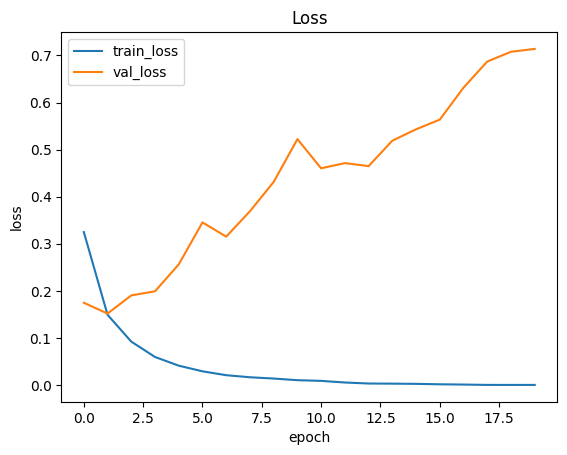

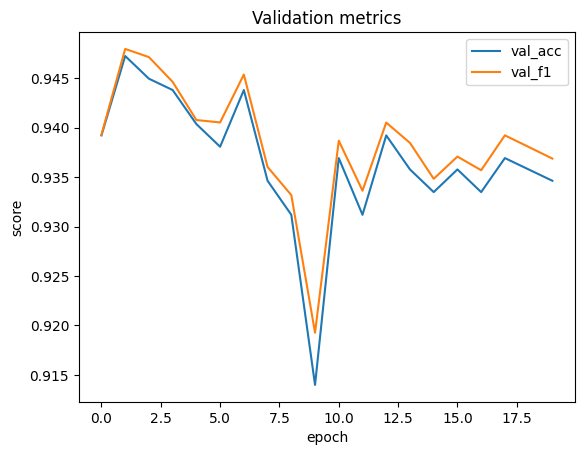

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history["val_acc"], label="val_acc")
plt.plot(history["val_f1"], label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.legend(); plt.title("Validation metrics")
plt.show()

# Test Ví dụ

In [33]:
model.eval()
sample_texts = [
    "This movie was absolutely wonderful!",
    "The script was boring and the acting was terrible."
]
enc = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
with torch.no_grad():
    logits, _ = model(enc["input_ids"], enc["attention_mask"])
preds = torch.argmax(logits, dim=-1).cpu().tolist()
for t, p in zip(sample_texts, preds):
    print(f"{t} -> {'Positive' if p==1 else 'Negative'}")

This movie was absolutely wonderful! -> Positive
The script was boring and the acting was terrible. -> Negative


In [34]:
ckpt_path = "/kaggle/working/modernbert_sst2_best.pt" if "KAGGLE_URL_BASE" in os.environ else "/content/modernbert_sst2_best.pt"
ckpt = torch.load(ckpt_path, map_location=device)
model = ModernBERTClassifier(ckpt["model_name"], num_labels=2).to(device)
model.load_state_dict(ckpt["model_state_dict"])
tokenizer = AutoTokenizer.from_pretrained(ckpt["tokenizer"])
print("Best val_acc:", ckpt["val_acc"])

Best val_acc: 0.9472477064220184


# So sánh SBERT và ModernBERT

In [43]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader

In [44]:
SBERT_NAME = "sentence-transformers/bert-base-nli-mean-tokens"
sbert_tokenizer = AutoTokenizer.from_pretrained(SBERT_NAME)

In [45]:
def sbert_tok_fn(batch):
    return sbert_tokenizer(
        batch["sentence"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

# Chuẩn bị Dataset

In [46]:
sbert_train = raw_ds["train"].map(sbert_tok_fn, batched=True)
sbert_val   = raw_ds["validation"].map(sbert_tok_fn, batched=True)

sbert_train = sbert_train.rename_column("label", "labels")
sbert_val   = sbert_val.rename_column("label", "labels")

sbert_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
sbert_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

BATCH_SIZE = 32
sbert_train_loader = DataLoader(sbert_train, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
sbert_val_loader   = DataLoader(sbert_val,   batch_size=BATCH_SIZE*2, shuffle=False, pin_memory=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

# Model SBERT

In [47]:
class SBERT2019Classifier(nn.Module):
    def __init__(self, model_name=SBERT_NAME, num_labels=2, dropout=0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)  # BERT base uncased
        hidden = self.backbone.config.hidden_size              # 768
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)

    @staticmethod
    def mean_pooling(last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)  # [B, L, 1]
        summed = (last_hidden_state * mask).sum(dim=1)                  # [B, H]
        denom = mask.sum(dim=1).clamp(min=1e-9)                         # [B, 1]
        return summed / denom

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        logits = self.classifier(self.dropout(pooled))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return logits, loss

# Train & Eval

In [48]:
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="SBERT train", leave=False):
        input_ids      = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels         = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
            logits, loss = model(input_ids, attention_mask, labels)

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    return total_loss / max(1, len(loader))

In [49]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    for batch in loader:
        input_ids      = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels         = batch["labels"].to(device, non_blocking=True)
        logits, _ = model(input_ids, attention_mask)
        pred = logits.argmax(dim=-1)
        preds.extend(pred.cpu().numpy().tolist())
        trues.extend(labels.cpu().numpy().tolist())
    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds)
    return acc, f1

# Chạy

In [51]:
EPOCHS = 10
LR = 2e-5

sbert_model = SBERT2019Classifier(num_labels=2).to(device)
optimizer   = torch.optim.AdamW(sbert_model.parameters(), lr=LR, weight_decay=0.01)
scaler      = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

hist_sbert = {"train_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(EPOCHS):
    tl = train_one_epoch(sbert_model, sbert_train_loader, optimizer, scaler)
    acc, f1 = evaluate(sbert_model, sbert_val_loader)
    hist_sbert["train_loss"].append(tl)
    hist_sbert["val_acc"].append(acc)
    hist_sbert["val_f1"].append(f1)
    print(f"[SBERT] Epoch {epoch+1}/{EPOCHS} | loss {tl:.4f} | val_acc {acc:.4f} | val_f1 {f1:.4f}")


[SBERT] Epoch 1/10 | loss 0.2395 | val_acc 0.9117 | val_f1 0.9140


[SBERT] Epoch 2/10 | loss 0.1500 | val_acc 0.9083 | val_f1 0.9132


[SBERT] Epoch 3/10 | loss 0.1238 | val_acc 0.9151 | val_f1 0.9185


[SBERT] Epoch 4/10 | loss 0.1121 | val_acc 0.9174 | val_f1 0.9202


[SBERT] Epoch 5/10 | loss 0.1296 | val_acc 0.9117 | val_f1 0.9116


[SBERT] Epoch 6/10 | loss 0.1580 | val_acc 0.9174 | val_f1 0.9195


[SBERT] Epoch 7/10 | loss 0.1767 | val_acc 0.9151 | val_f1 0.9174


[SBERT] Epoch 8/10 | loss 0.1600 | val_acc 0.9163 | val_f1 0.9186


[SBERT] Epoch 9/10 | loss 0.1354 | val_acc 0.9243 | val_f1 0.9265


[SBERT] Epoch 10/10 | loss 0.1373 | val_acc 0.9186 | val_f1 0.9190


# So sánh SBERT và ModernBERT

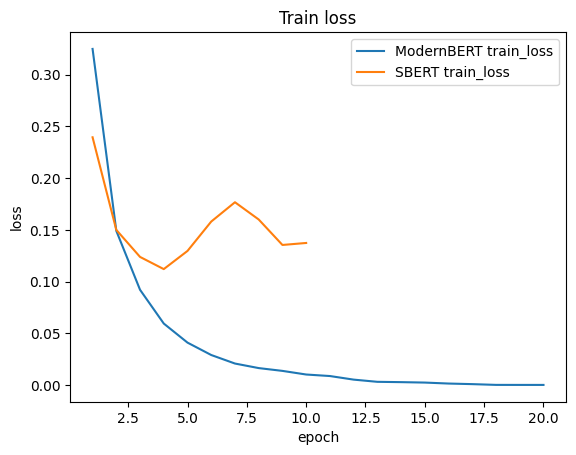

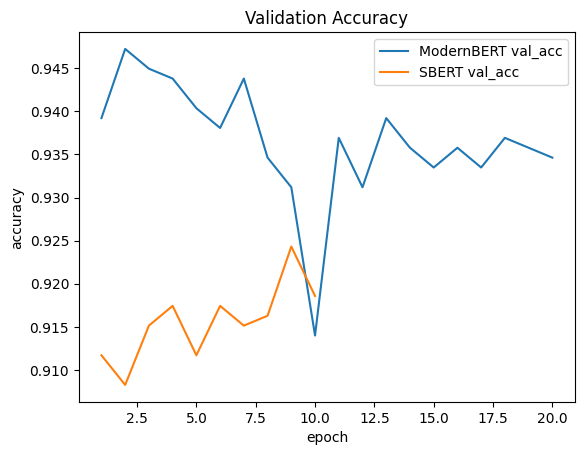

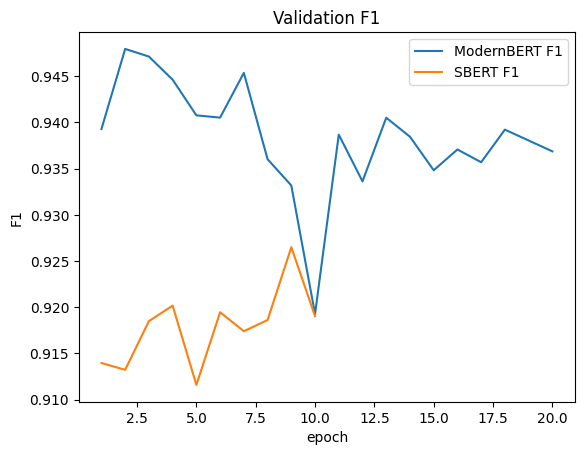

In [54]:
import matplotlib.pyplot as plt

epochs_modernbert = range(1, len(history["val_acc"])+1)
epochs_sbert = range(1, len(hist_sbert["val_acc"])+1)

# Train Loss
plt.figure()
plt.plot(epochs_modernbert, history["train_loss"], label="ModernBERT train_loss")
plt.plot(epochs_sbert, hist_sbert["train_loss"], label="SBERT train_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train loss")
plt.legend()
plt.show()

# Validation Accuracy
plt.figure()
plt.plot(epochs_modernbert, history["val_acc"], label="ModernBERT val_acc")
plt.plot(epochs_sbert, hist_sbert["val_acc"], label="SBERT val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

# F1
plt.figure()
plt.plot(epochs_modernbert, history["val_f1"], label="ModernBERT F1")
plt.plot(epochs_sbert, hist_sbert["val_f1"], label="SBERT F1")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.title("Validation F1")
plt.legend()
plt.show()

